# COVID

COVID is, of course, the thing that worries people the most about attending a conference or workshop. Two questions dug into this in a bit more detail.


In [1]:
from config import survey, default_color, plot_wordcloud, make_wordcloud
import pandas as pd
import numpy as np
import altair as alt


First, repeating from the attendance section, we can see the high level things that worry people most about attending.

In [2]:
# We meed top use the numpy argsort to do this: pandas doesn't really work accross columns like this.
worried = survey[['worried_covid', 'worried_funding', 'worried_length', 'worried_accessibility', 'worried_responsibilities']].to_numpy()
worried_argsort = worried.argsort()
worried_desc = [
    'COVID',
    'Funding',
    'Workshop Length',
    'Accessibility',
    'Other Responsibilities'
]

most_worried_list = []
most_worried = worried_argsort[:1]
worried_sort = np.copy(worried)
worried_sort.sort(axis=1)

for idx in range(5):
    mask = worried_sort[:,0] == worried_sort[:, idx]
    worried_idx_list = worried_argsort[mask, idx]
    worried_idx_sort_list = worried_sort[mask, idx]
    do_not_worry = worried_idx_sort_list < 4
    most_worried_list += list(worried_idx_list[do_not_worry])

most_worried = [worried_desc[i] for i in most_worried_list]

(alt.Chart(data=pd.DataFrame(most_worried, columns=['worried']), title="Most Worried About Attending")
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="worried", sort='-x', title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("count():N"),
    )
)

alt.Chart(...)

We asked people to select a point on this figure to describe at what level of infection rate they would be comfortable attending.

![COVID Rates pulled from the NYTimes](covid_rates.png)

In [3]:
(alt.Chart(data=survey, title="COVID Comfort Level")
    .transform_joinaggregate(total='count(*)')
    .transform_calculate(pct='1 / datum.total')
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="covid_comfort:N", sort=['A', 'B', 'C', 'D', 'E', 'At No Level', 'Travel Restrictions'], title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("sum(pct):N", format=".0%"),
    )
)

alt.Chart(...)

We had not expected travel restrictions to be a stronger factor than the COVID level (the exact wording in the survey was "My institution's or country's travel restrictions related to COVID are the concern more than the case load")! To dig into that a little more, considering how often we've seen the DOE travel restrictions mentioned, we can split this out with an interactive plot by employer:

In [4]:
brush = alt.selection_single(encodings=['y'])

emp = (alt.Chart(data=survey, title="Employer?")
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="employed_by:N", sort='-x', title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("count():N"),
        color=alt.condition(brush, default_color, alt.value('orange'))
    )
    .add_selection(brush)
)

covid = (alt.Chart(data=survey, title="COVID Comfort Level")
    .transform_joinaggregate(total='count(*)')
    .transform_calculate(pct='1 / datum.total')
    .mark_bar()
    .transform_filter(brush)
    .encode(
        y=alt.Y(shorthand="covid_comfort:N", sort=['A', 'B', 'C', 'D', 'E', 'At No Level', 'Travel Restrictions'], title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("sum(pct):N", format=".0%"),
    )
)

emp & covid

alt.VConcatChart(...)

As expected - at national labs the travel restirctions out weight by far everything else.

And by looking at weather or not people will attend can tell us a bit about how much they have factored the risk into this:

In [5]:
brush = alt.selection_single(encodings=['y'])

attend_histo = (
    alt.Chart(data=survey, title="Would you attend?")
       .transform_joinaggregate(total='count(*)')
       .transform_calculate(pct='1 / datum.total')
       .mark_bar()
       .encode(
           x=alt.X(shorthand="count(attend)"),
           y=alt.Y(shorthand="attend:N", title="", sort="-x"),
           color=alt.condition(brush, default_color, alt.value('orange'))
       )
)
attend_text = (
    attend_histo.mark_text(align="right", dx=-3)
                .encode(
                    text=alt.Text("sum(pct):Q", format=".0%"),
                    color=alt.value("white")
                )
)

covid = (alt.Chart(data=survey, title="COVID Comfort Level")
    .transform_joinaggregate(total='count(*)')
    .transform_calculate(pct='1 / datum.total')
    .mark_bar()
    .transform_filter(brush)
    .encode(
        y=alt.Y(shorthand="covid_comfort:N", sort=['A', 'B', 'C', 'D', 'E', 'At No Level', 'Travel Restrictions'], title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("sum(pct):N", format=".0%"),
    )
)

(attend_histo.add_selection(brush) + attend_text) & covid

alt.VConcatChart(...)

Selecting the "Would Not Attend" bar and we can see that many more people indicate they would only be willing to travel at point E.

## Full Perspective on COVID

We asked for further thoughts than comfort level. Here is a word cloud of what we got back along with a few quick paraphrasings of some comments.

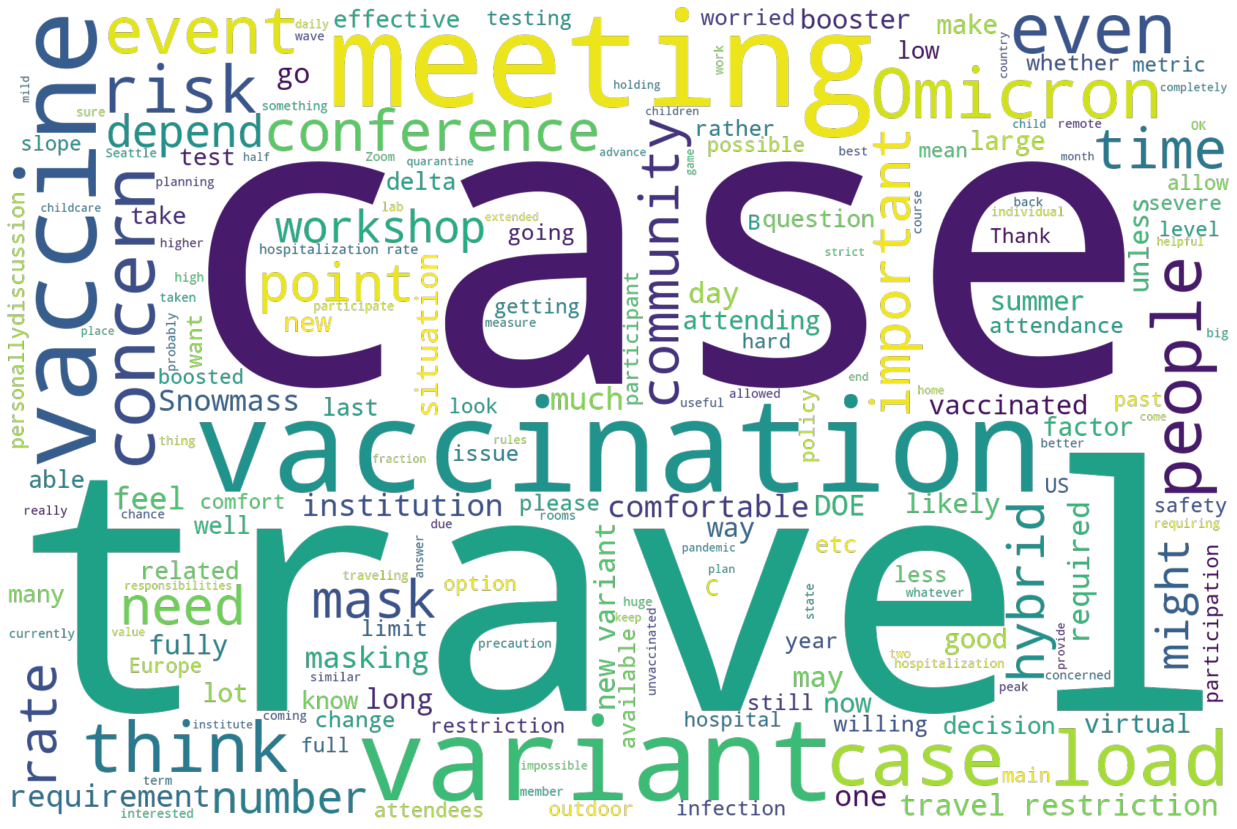

In [6]:
plot_wordcloud(make_wordcloud(survey['covid_comments'], ['person', 'COVID', 'attend']))

People wrote a lot in response to this questions - this was the only questions where we consistently got paragraphs of text back. I'm not 100% sure the word cloud does best to transfer the information. That said, using the above words as a clue, here is our best attempt at a summary:

* travel: DOE (by far the most common comment), international restrictions
* significant worry about a new varient that manages to avoid the vaccine
* Rules on masking, vaccination for attendees
* Masks should be provided
* Several people were worried about the low vaccination rate in the USA compared to other Western countries
* Also a number of comments about vaccinations being a "game-changer" and, the person, is willing to travel as a result.
* Some worry about ICU as opposed to the infection rate (especially as the varients change character)